<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>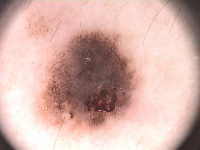</td><td>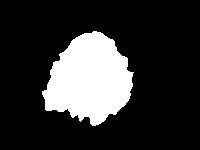</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
%%capture
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

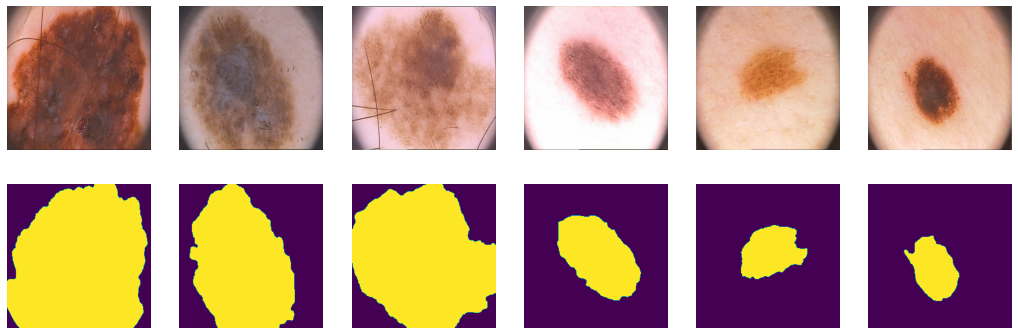

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

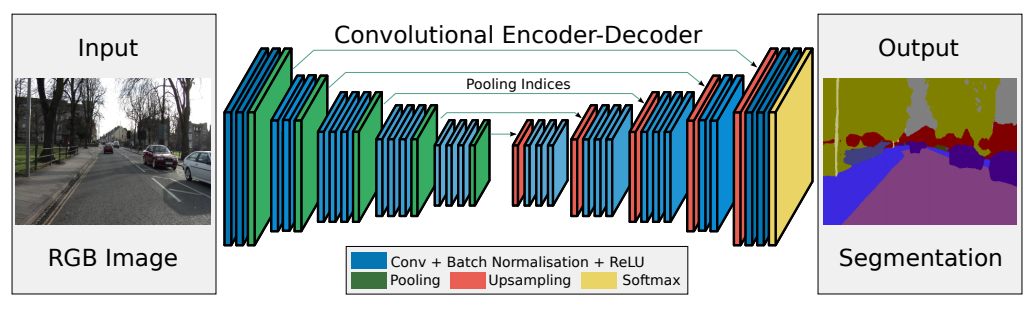

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

основная часть работы была выполнена мной в прошлом потоке https://colab.research.google.com/drive/1dTacoe_1cDKPzyVJSOtT9TGNzmcZy62F?usp=sharing#scrollTo=aQhewM2R8dY_ но были добавлены доп. лоссы

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0=nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec0=nn.BatchNorm2d(64)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec1=nn.BatchNorm2d(64)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2=nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        self.bn_dec3=nn.BatchNorm2d(64)
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.bn_dec0(self.upsample0(b))))
        d1 = F.relu(self.dec_conv1(self.bn_dec1(self.upsample1(d0))))
        d2 = F.relu(self.dec_conv2(self.bn_dec2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec3(self.upsample3(d2)) ) # no activation
        d3 = torch.softmax(d3,dim=1)
        return d3
  

In [15]:

class SegNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SegNet, self).__init__()
        
        # encoder (downsampling)
        
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(32)
        self.enc_conv0_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.enc_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5 = nn.BatchNorm2d(128)
        self.enc_conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.norm7 = nn.BatchNorm2d(256)
        self.enc_conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.norm8 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.norm9 = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.norm10 = nn.BatchNorm2d(128)
        self.dec_conv0_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm11 = nn.BatchNorm2d(128)
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.norm12 = nn.BatchNorm2d(64)
        self.dec_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm13 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.norm14 = nn.BatchNorm2d(32)
        self.dec_conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm15 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.norm16 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        x = self.norm0(F.relu(self.enc_conv0(x)))
        x = self.norm1(F.relu(self.enc_conv0_1(x)))
        x = self.pool0(x)
        
        x = self.norm2(F.relu(self.enc_conv1(x)))
        x = self.norm3(F.relu(self.enc_conv1_1(x)))
        x = self.pool1(x)
        
        x = self.norm5(F.relu(self.enc_conv2(x)))
        x = self.norm6(F.relu(self.enc_conv2_1(x)))
        x = self.pool2(x)

        x = self.norm7(F.relu(self.enc_conv3(x)))
        x = self.norm8(F.relu(self.enc_conv3_1(x)))
        x = self.pool3(x)

        # bottleneck
        x = self.norm9(self.bottleneck_conv(x))

        # decoder (upsampling)
        x = self.upsample0(x)
        x = self.norm10(F.relu(self.dec_conv0(x)))
        x = self.norm11(F.relu(self.dec_conv0_1(x)))
        
        x = self.upsample1(x)
        x = self.norm12(F.relu(self.dec_conv1(x)))
        x = self.norm13(F.relu(self.dec_conv1_1(x)))
        x = self.upsample2(x)
        x = self.norm14(F.relu(self.dec_conv2(x)))
        x = self.norm15(F.relu(self.dec_conv2_1(x)))

        x = self.upsample3(x)
        x =self.norm16(self.dec_conv3(x))
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
# def bce_loss(y_real, y_pred, eps = 1e-6):
#     # TODO 
#     # please don't use nn.BCELoss. write it from scratch
#     y_pred = torch.sigmoid(y_pred)
#     return (torch.clamp(y_pred, min=eps) - y_pred * y_real + torch.log1p(torch.exp(-torch.abs(y_pred)))).mean()

def bce_loss(y_pred, y_real):
    return (torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log1p(torch.exp(-torch.abs(y_pred)))).mean()
    # return (torch.clamp(y_pred, min=0) - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [20]:
def train_simple(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        history.append((train_loss, train_acc, val_loss, val_acc, ts_loss, ts_acc))
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(Y_pred).cpu().detach().numpy()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
            
    return history

In [21]:
def train(model, opt, loss_fn, epochs=100, data_tr=None, data_val=None,  data_ts=None):
    if data_tr is None:
      data_tr = data_tr
    if data_val is None:
      data_val = data_val
    if data_ts is None:
      data_ts = data_ts
    X_val, Y_val = next(iter(data_val))
    history = []
    last_acc = None
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        corr = 0
        processed_size=0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            corr += iou_pytorch(torch.sigmoid(model(X_batch.to(device)))>0.5, Y_batch.to(device)).mean().item()
            processed_size += X_batch.size(0)
        train_loss = avg_loss
        train_acc = corr/len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # визуализируем получаемые на каждой эпохе результаты
        model.eval()  # testing mode 
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        for inputs, labels in data_val: 
          inputs = inputs.to(device)
          labels = labels.to(device)
          with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss = loss_fn(preds, labels)
          running_loss += loss.item() / len(data_val)
          running_corrects += iou_pytorch(torch.sigmoid(model(inputs))>0.5, labels).mean().item()
          processed_size += inputs.size(0)
        val_loss = running_loss 
        val_acc = running_corrects/len(data_val)

        model.eval()  # testing mode
        test_loss = 0.0
        test_running_corrects = 0
        for inputs_ts, labels_ts in data_ts: #Тест
          inputs_ts = inputs_ts.to(device)
          labels_ts = labels_ts.to(device)
          with torch.set_grad_enabled(False):
            preds = model(inputs_ts)
            loss = loss_fn(preds, labels_ts)
          test_loss += loss.item() / len(data_ts)
          test_running_corrects += iou_pytorch(torch.sigmoid(model(inputs_ts))>0.5, labels_ts).mean().item()
        ts_loss = test_loss 
        ts_acc = test_running_corrects/len(data_ts)
        Y_hat_val = torch.sigmoid(model(X_val.to(device))).cpu().detach().numpy()
        Y_hat_train = torch.sigmoid(Y_pred).cpu().detach().numpy()
        X_batch = X_batch.cpu().detach().numpy()
        Y_batch = Y_batch.cpu().detach().numpy()

        # визуализируем получаемые на каждой эпохе результаты
        clear_output(wait=True)

        row_names = ['Image', 'Mask Predicted',
                     'Mask Truth']


        fig, big_axes = plt.subplots( figsize=(12, 8) , nrows=3, ncols=1, sharey=True) 
        for row, big_ax in enumerate(big_axes, start=1):
            big_ax.set_title(row_names[row-1], fontsize=16)

            
            big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
            
            big_ax._frameon = False

        for k in range(6):
            ax = fig.add_subplot(3, 6, k+1)
            ax.imshow(X_val[k, 0], cmap='gray')
            plt.axis('off')
            fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

            ax = fig.add_subplot(3, 6, k+7)
            plt.imshow(Y_hat_val[k, 0]>0.5, cmap='gray')
            plt.axis('off')

            ax = fig.add_subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.axis('off')

        fig.set_facecolor('w')
        plt.tight_layout()
        plt.show()

        
        history.append((train_loss, train_acc, val_loss, val_acc, ts_loss, ts_acc))
        if last_acc is None:
          last_acc = ts_acc
        elif last_acc>ts_acc:
          return history
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [22]:
@torch.no_grad()
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [23]:
model = SegNet().to(device)

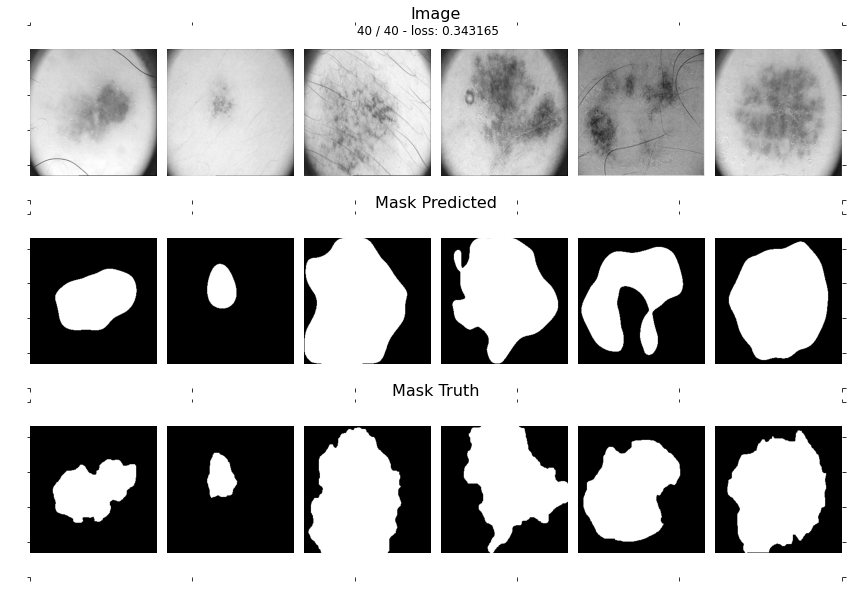

In [25]:
model = SegNet().to(device)
max_epochs = 40
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, data_ts)

In [26]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.7540000081062317

Ответьте себе на вопрос: не переобучается ли моя модель?

да, обычная довольно быстро переобучается, игрался с lr , помогает, но несильно (bce_loss может уйти в минус из-за нестабильности, пытался решить clap) в конечном счете решил нормализовывать батчами, и взял модель segnet с нормализацией, вообще по хорошему нужно было проверить на scheduler

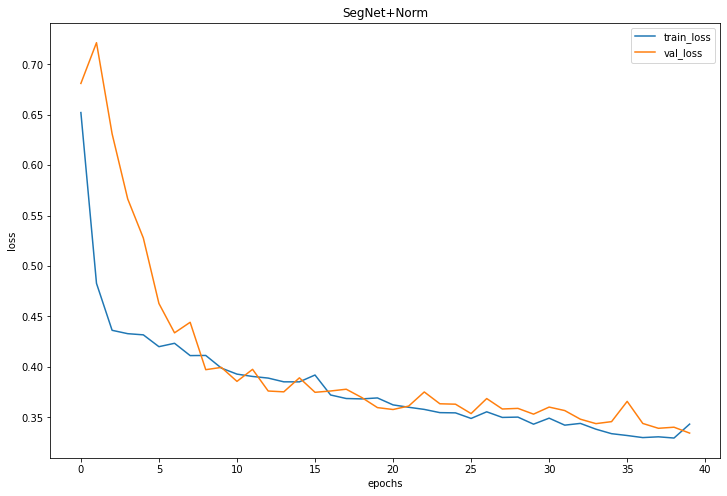

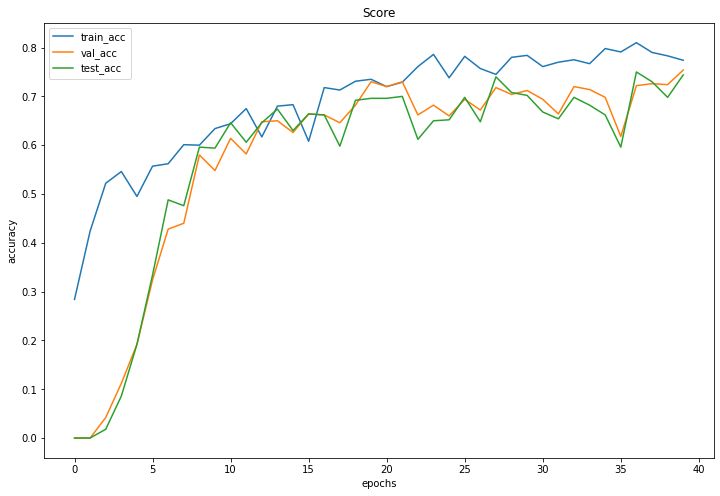

In [27]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+Norm')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [28]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = (2 * (y_real * y_pred)).sum()
    den =  (y_real + y_pred).sum()
    res = 1 - (num / den) * (1 / (256 * 256))
    return res 

Проводим тестирование:

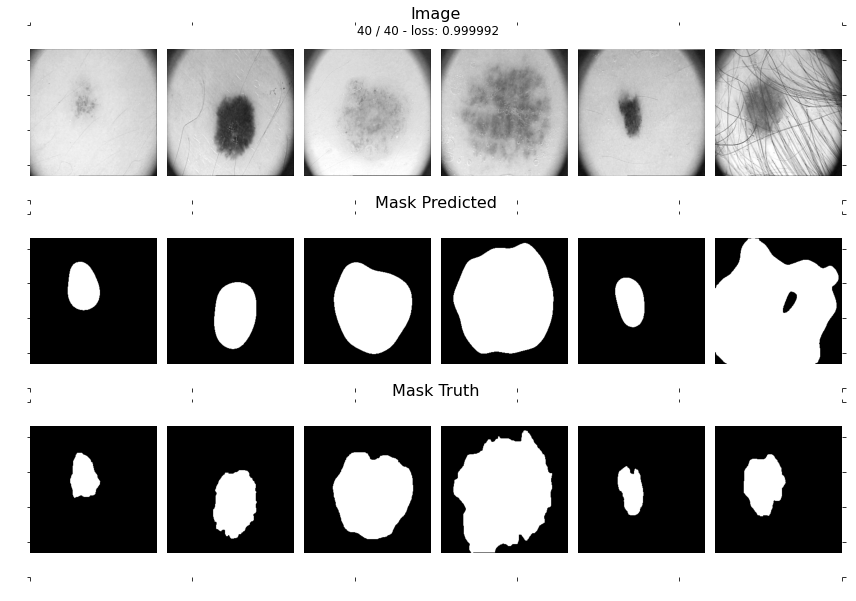

In [30]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
history = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, data_ts)

In [31]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.7059999704360962

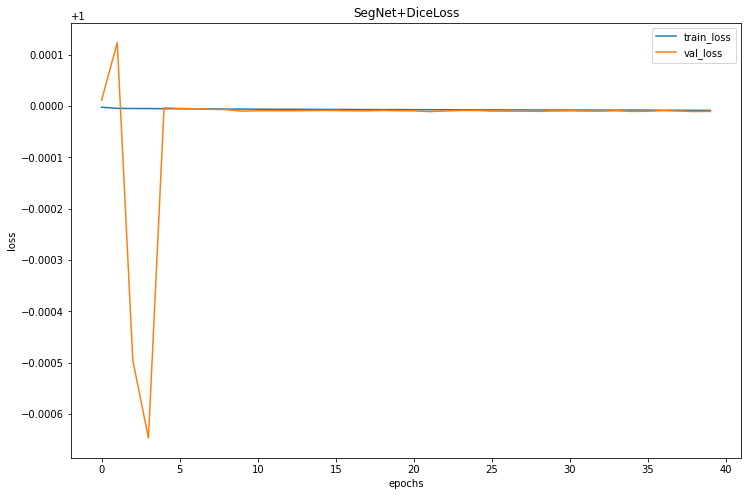

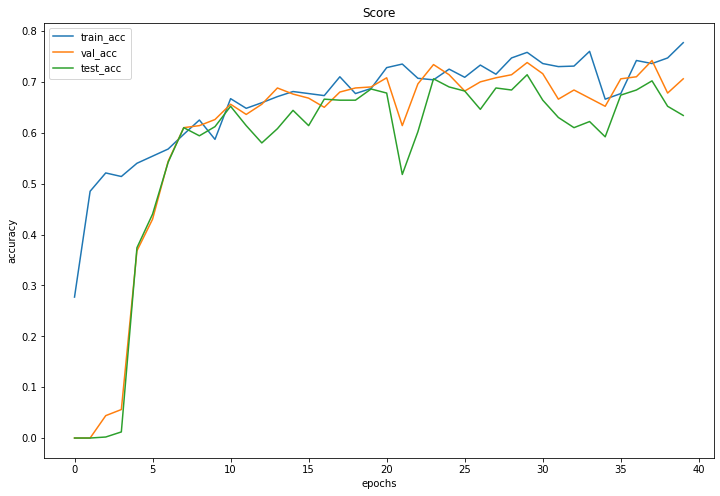

In [32]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [33]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2, alpha = 1):
    y_pred = torch.sigmoid(y_pred)
    BCE = bce_loss(y_real, y_pred) #clamp here
    pt = torch.exp(-BCE) 
    return torch.mean(alpha * (1-pt)**gamma * BCE)
    # y_pred =  # hint: torch.clamp
    # return your_loss

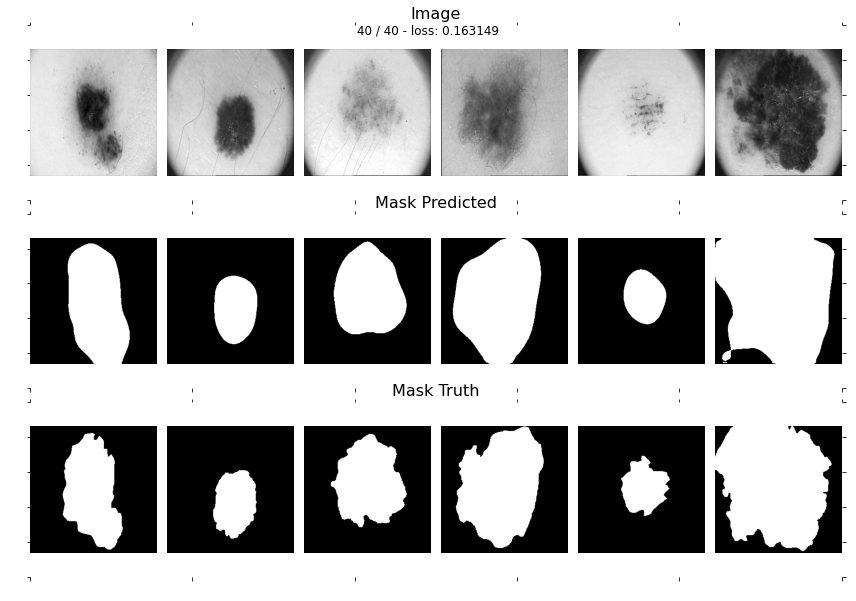

In [34]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
history = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, data_ts)

In [35]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.6080000102519989

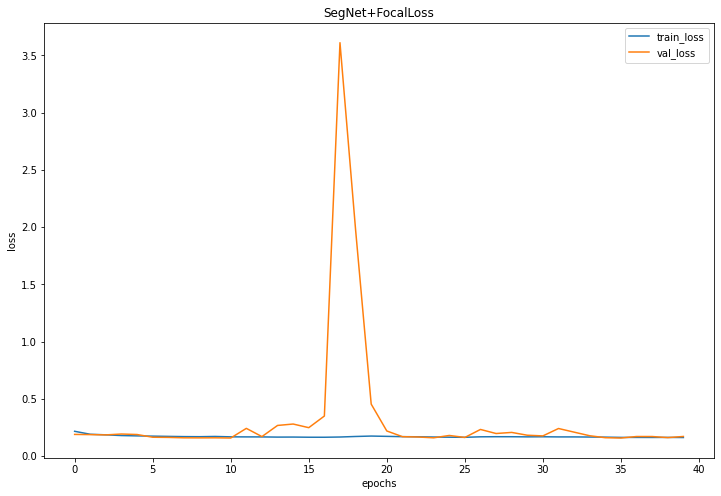

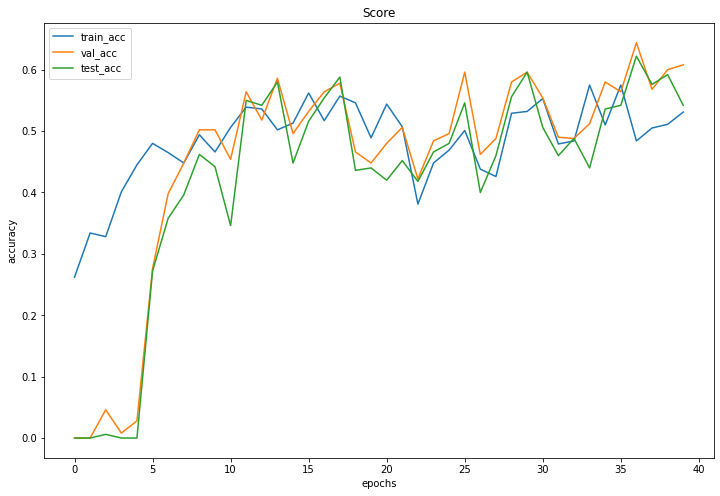

In [36]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### segmentation_loss

не помню откуда взял этот лосс, по моему отсюда https://github.com/JunMa11/SegLoss , но идея довольна проста, использовать оба лосса

In [37]:
def segmentation_loss(y_real, y_pred):
    return bce_loss(y_real, y_pred) + dice_loss(y_real, y_pred)

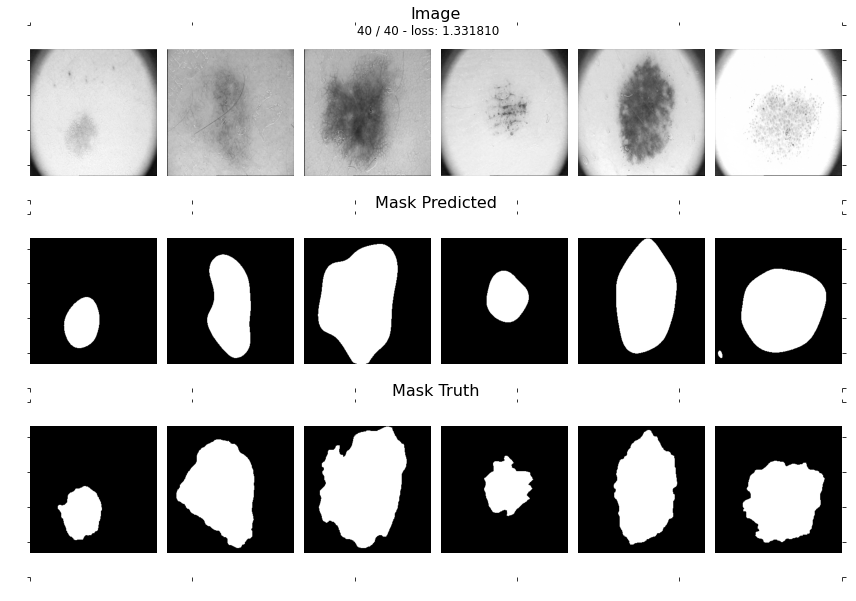

In [38]:
model = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, segmentation_loss, max_epochs, data_tr, data_val, data_ts)

In [39]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.7219999432563782

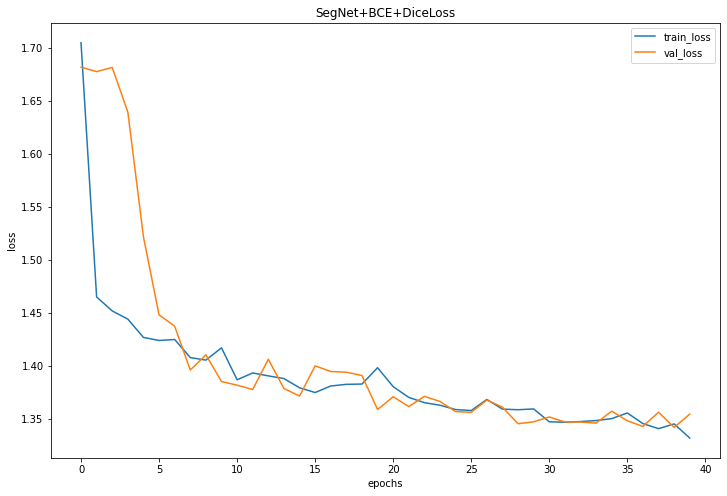

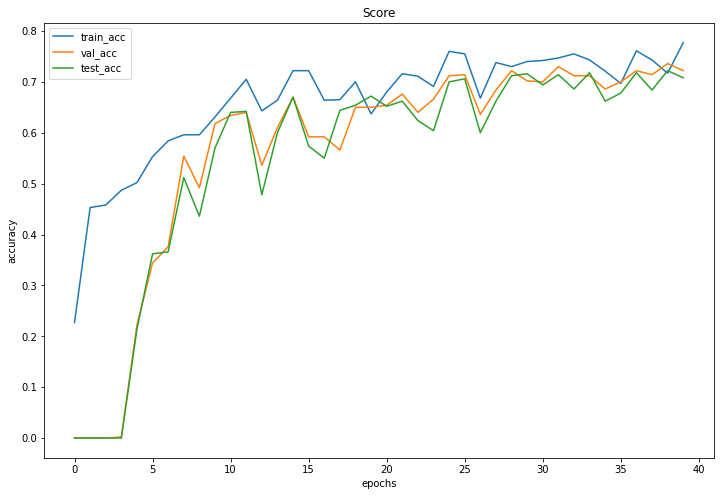

In [40]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+BCE+DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### lovasz

In [41]:
import torch
import torch.nn as nn

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


class LovaszSoftmax(nn.Module):
    """
    https://github.com/JunMa11/SegLoss/blob/master/losses_pytorch/lovasz_loss.py
    """
    def __init__(self, reduction='mean'):
        super(LovaszSoftmax, self).__init__()
        self.reduction = reduction

    def prob_flatten(self, input, target):
        assert input.dim() in [4, 5]
        num_class = input.size(1)
        if input.dim() == 4:
            input = input.permute(0, 2, 3, 1).contiguous()
            input_flatten = input.view(-1, num_class)
        elif input.dim() == 5:
            input = input.permute(0, 2, 3, 4, 1).contiguous()
            input_flatten = input.view(-1, num_class)
        target_flatten = target.view(-1)
        return input_flatten, target_flatten

    def lovasz_softmax_flat(self, inputs, targets):
        num_classes = inputs.size(1)
        losses = []
        for c in range(num_classes):
            target_c = (targets == c).float()
            if num_classes == 1:
                input_c = inputs[:, 0]
            else:
                input_c = inputs[:, c]
            loss_c = (torch.autograd.Variable(target_c) - input_c).abs()
            loss_c_sorted, loss_index = torch.sort(loss_c, 0, descending=True)
            target_c_sorted = target_c[loss_index]
            losses.append(torch.dot(loss_c_sorted, torch.autograd.Variable(lovasz_grad(target_c_sorted))))
        losses = torch.stack(losses)

        if self.reduction == 'none':
            loss = losses
        elif self.reduction == 'sum':
            loss = losses.sum()
        else:
            loss = losses.mean()
        return loss

    def forward(self, inputs, targets):
        # print(inputs.shape, targets.shape) # (batch size, class_num, x,y,z), (batch size, 1, x,y,z)
        inputs, targets = self.prob_flatten(inputs, targets)
        # print(inputs.shape, targets.shape)
        losses = self.lovasz_softmax_flat(inputs, targets)
        return losses

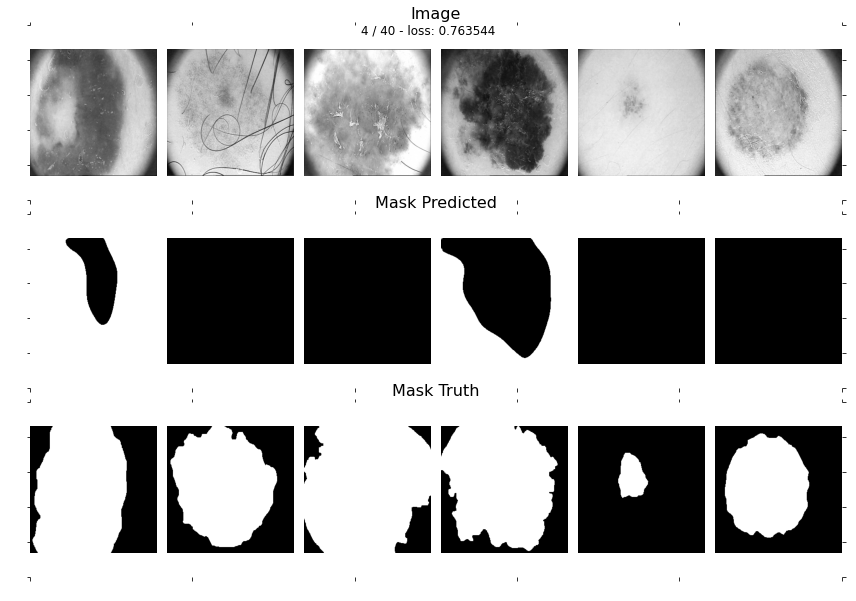

In [43]:
model = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, LovaszSoftmax(), max_epochs, data_tr, data_val, data_ts)

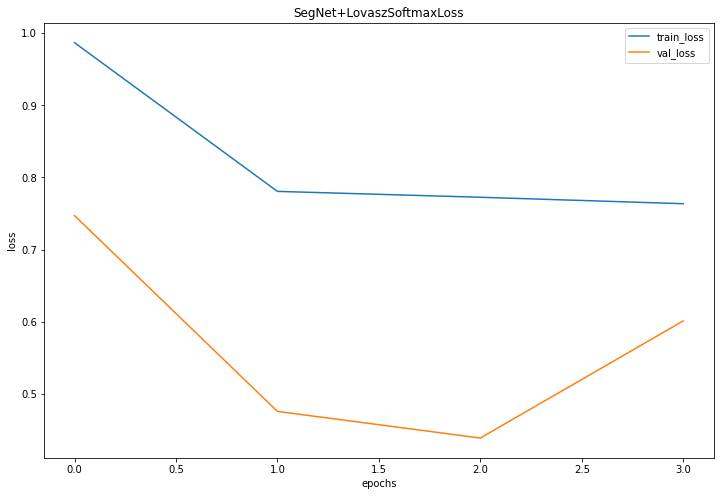

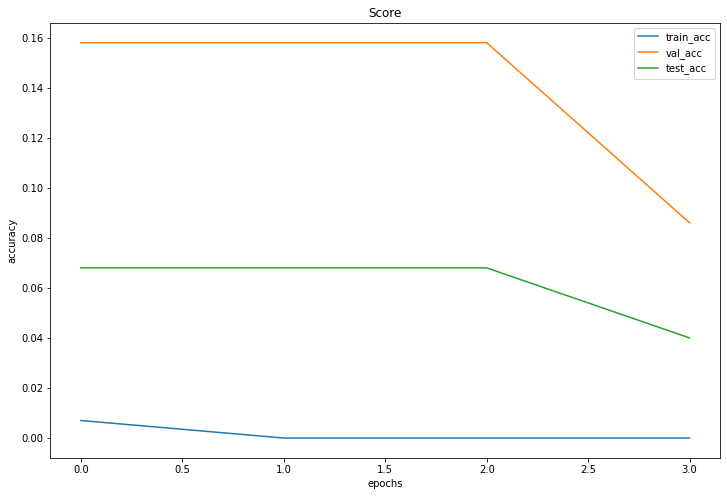

In [44]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+LovaszSoftmaxLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [45]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.0859999991953373

плохо, совсем плохо, тренировка остановилась из-за ухудшения по качеству, почти сразу

In [52]:
import cv2 as cv
import numpy as np

import torch
from torch import nn

from scipy.ndimage.morphology import distance_transform_edt as edt
from scipy.ndimage import convolve

"""
Hausdorff loss implementation based on paper:
https://arxiv.org/pdf/1904.10030.pdf
copy pasted from - all credit goes to original authors:
https://github.com/SilmarilBearer/HausdorffLoss
"""


class HausdorffDTLoss(nn.Module):
    """Binary Hausdorff loss based on distance transform"""

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        # pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.detach().cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error.to(device) * distance.to(device)
        loss = dt_field.mean()

        return loss

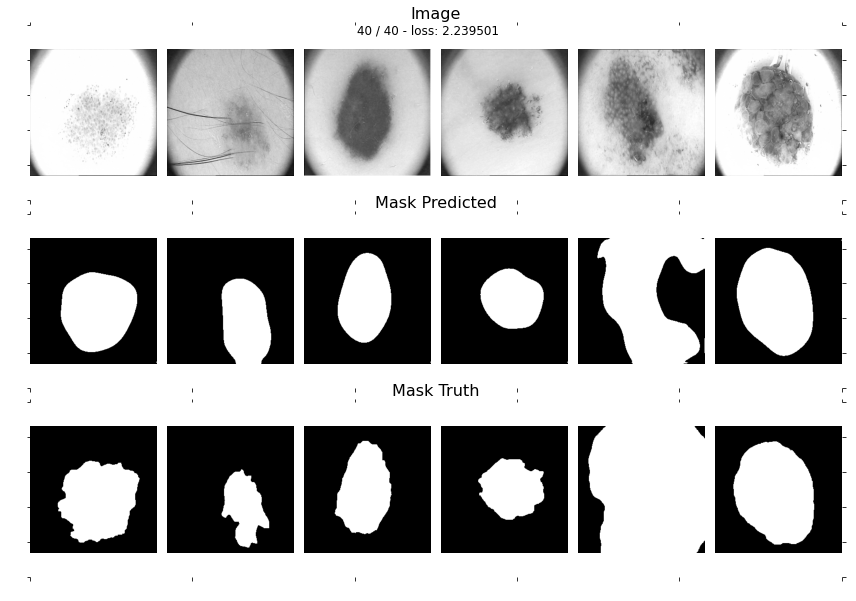

In [54]:
model = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model.parameters())
#  параметер alpha был подобран опытным путем
history=train(model, optimaizer, HausdorffDTLoss(alpha=.5), max_epochs, data_tr, data_val, data_ts)

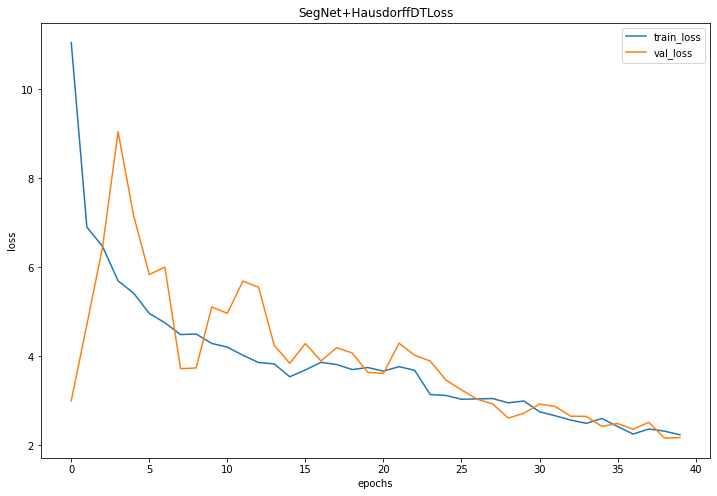

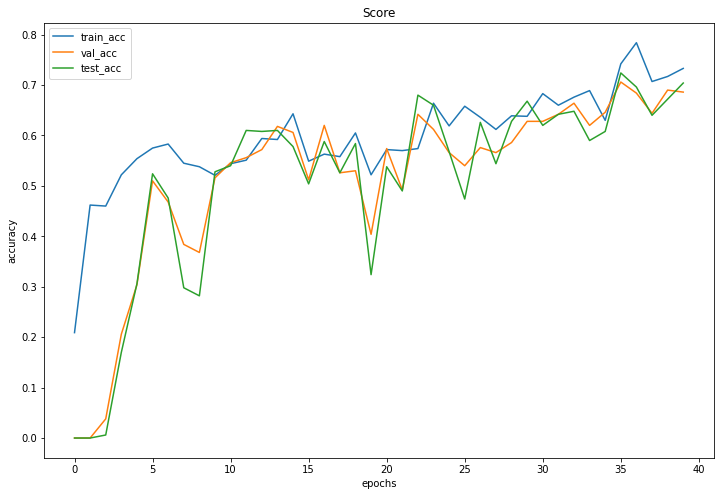

In [55]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+HausdorffDTLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [56]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.6859999895095825

In [57]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class ASLSingleLabel(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []  # prevent gpu repeated memory allocation
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target, reduction=None):
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes.mul_(1 - self.eps).add_(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss


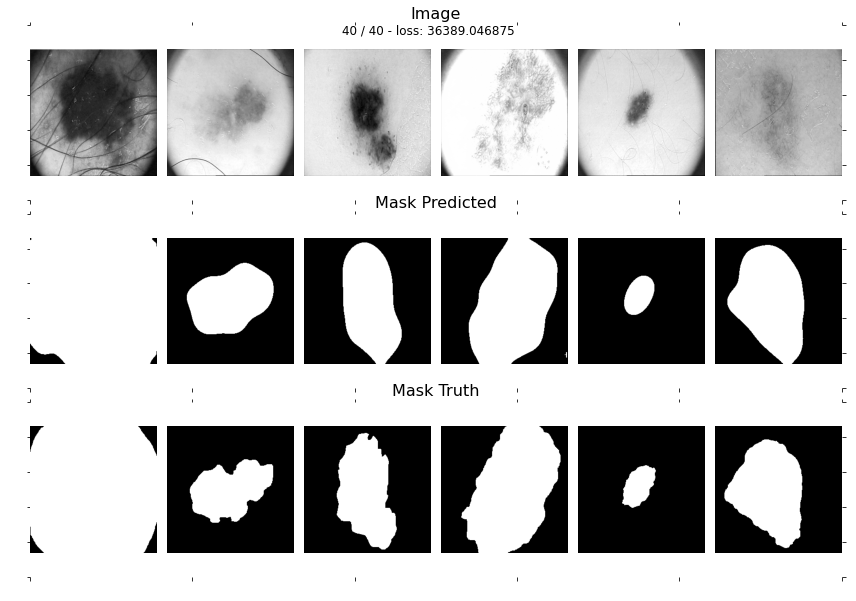

In [58]:
model = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, AsymmetricLossOptimized(), max_epochs, data_tr, data_val, data_ts)

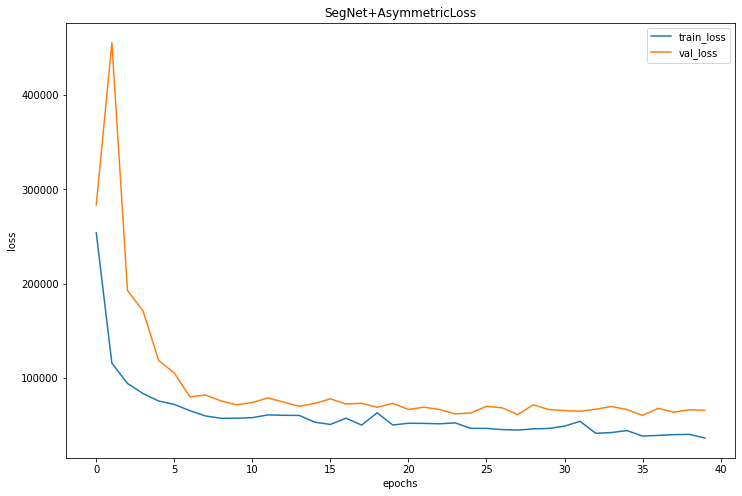

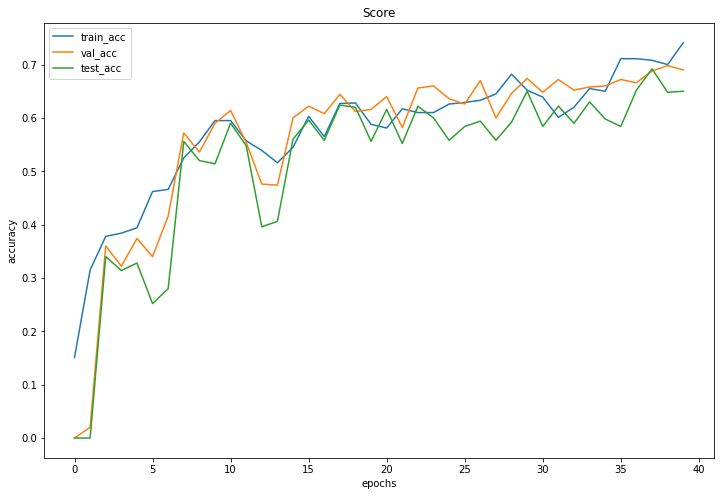

In [59]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+AsymmetricLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [60]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.6900000274181366

это лосс из другой "оперы"(классификации), но применил его ради интереса, странно, что он показал неплохой результат(>50;))

https://arxiv.org/abs/2009.14119

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

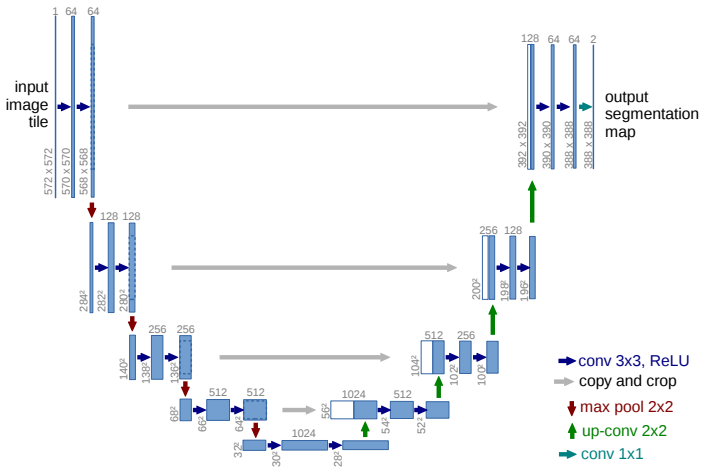

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [61]:
class UNet(nn.Module):
  def __init__(self):
        super().__init__()
        # encoder (downsampling)
        
        self.layer0= nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(2, stride = 2)  # 256 -> 128
        
        self.layer1= nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2, stride = 2) # 128 -> 64
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),)
        self.pool2 = nn.MaxPool2d(2, stride = 2) # 64 -> 32

        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2, stride = 2)

        # bottleneck
        self.bottleneck =  nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256))
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))

        self.upsample2 = nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))

        self.upsample3 = nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1))
        
  def forward(self, x):
        x = self.layer0(x)
        conv1 = torch.clone(x)
        x = self.pool0(x)
        
        x = self.layer1(x)
        conv2 = torch.clone(x)
        x = self.pool1(x)
        
        x = self.layer2(x)
        conv3 = torch.clone(x)
        x = self.pool2(x)

        x = self.layer3(x)
        conv4 = torch.clone(x)
        x = self.pool3(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder (upsampling)
        x = torch.cat((self.upsample0(x), conv4),1)
        x = self.dec_conv0(x)
        
        x = torch.cat((self.upsample1(x), conv3),1)
        x = self.dec_conv1(x)

        x = torch.cat((self.upsample2(x), conv2),1)
        x = self.dec_conv2(x)

        x =torch.cat((self.upsample3(x), conv1),1)
        x =self.dec_conv3(x)
        return x

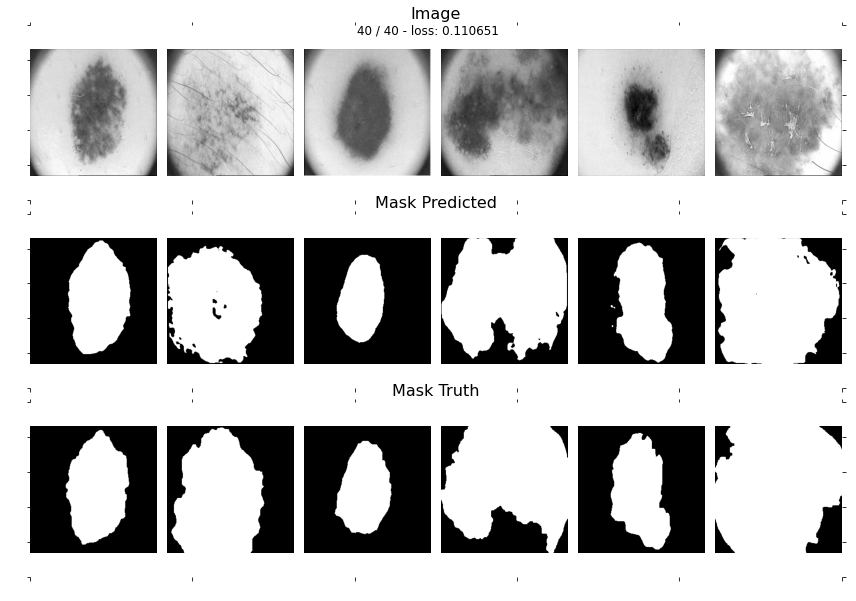

In [62]:
unet_model = UNet().to(device)
history = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 40, data_tr, data_val, data_ts)

In [63]:
score_model(unet_model, iou_pytorch, data_val)

0.714000016450882

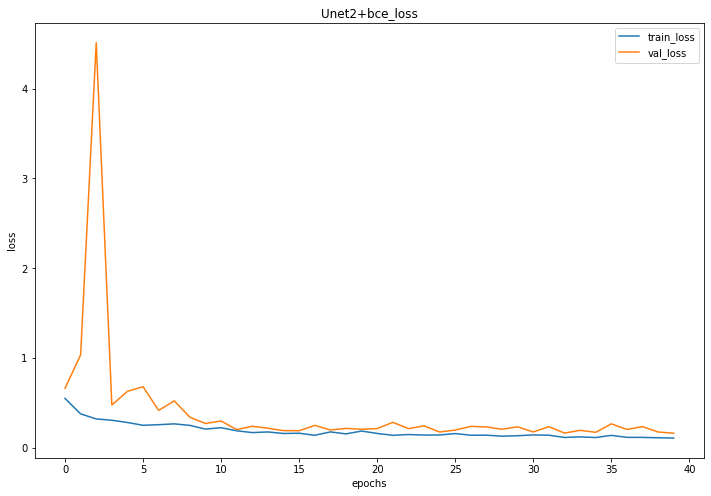

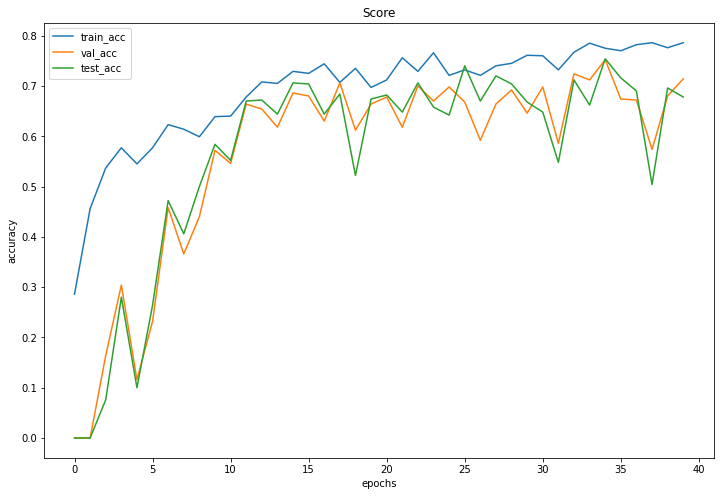

In [64]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+bce_loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

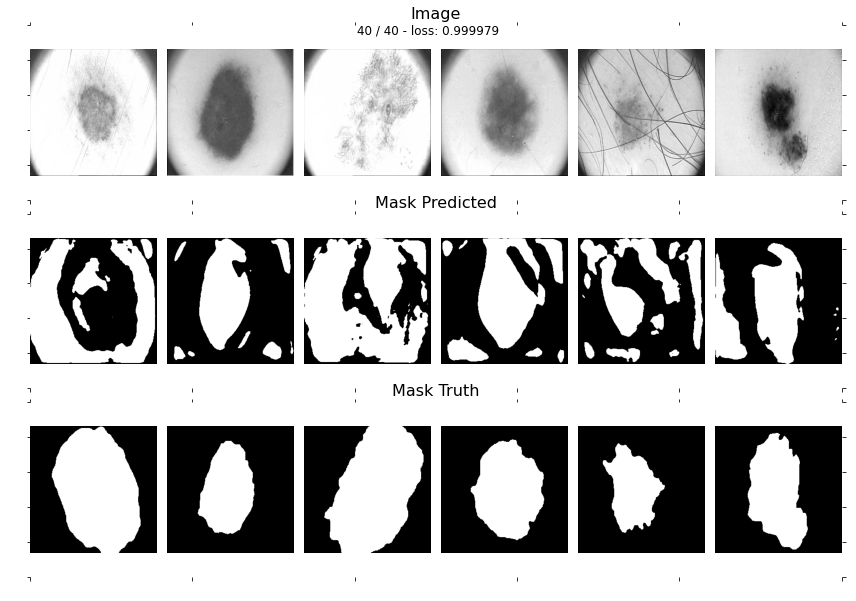

In [65]:
unet_model = UNet().to(device)
history = train(unet_model, optim.Adam(unet_model.parameters()), dice_loss, 40, data_tr, data_val, data_ts)

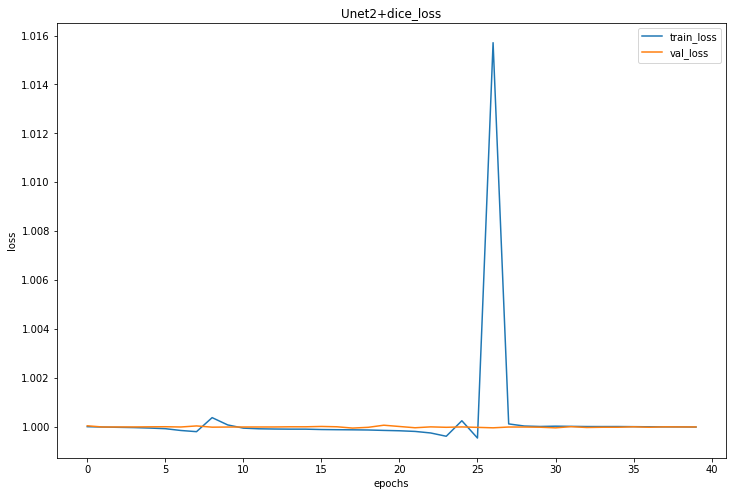

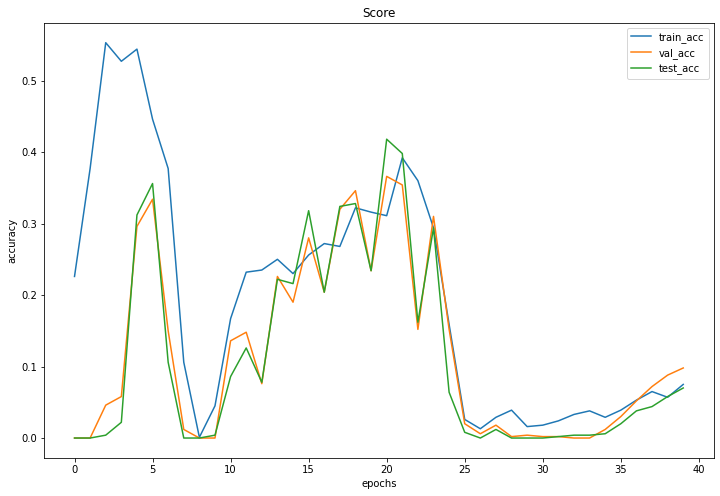

In [66]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+dice_loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [67]:
score_model(unet_model, iou_pytorch, data_val)

0.09799999371170998

In [86]:
def segmentation_loss(y_real, y_pred, alpha=0.2):
    # взвешенный segmentation_loss
    return (1-alpha)*bce_loss(y_real, y_pred) + alpha*dice_loss(y_real, y_pred)

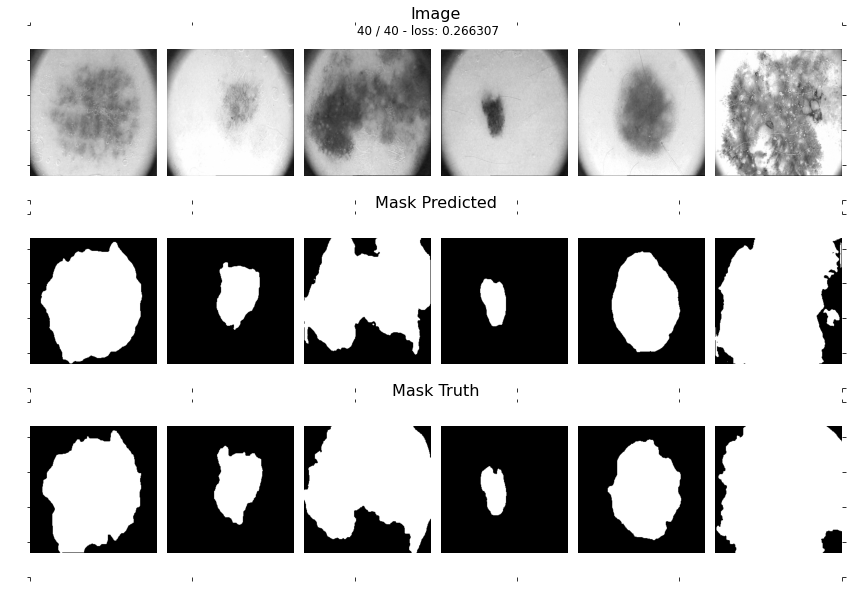

In [87]:
unet_model = UNet().to(device)
history = train(unet_model, optim.Adam(unet_model.parameters()), segmentation_loss, 40, data_tr, data_val, data_ts)

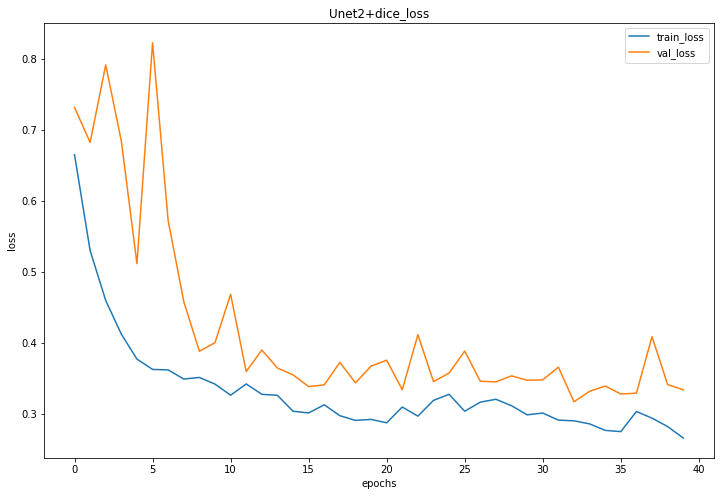

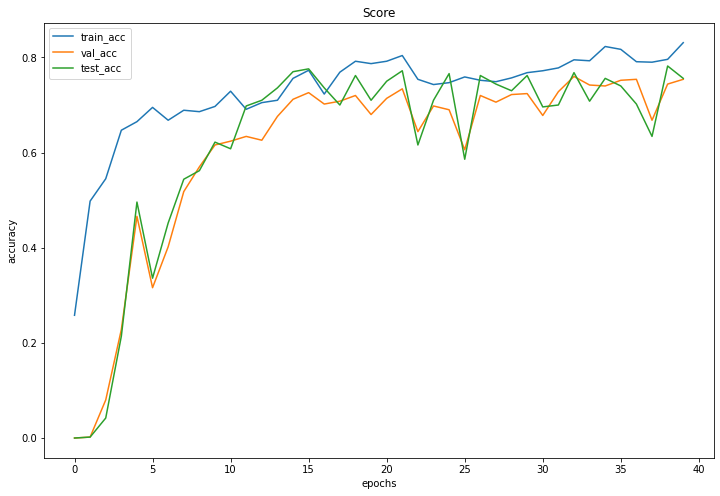

In [88]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+dice_loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [89]:
score_model(unet_model, iou_pytorch, data_val)

0.7539999783039093

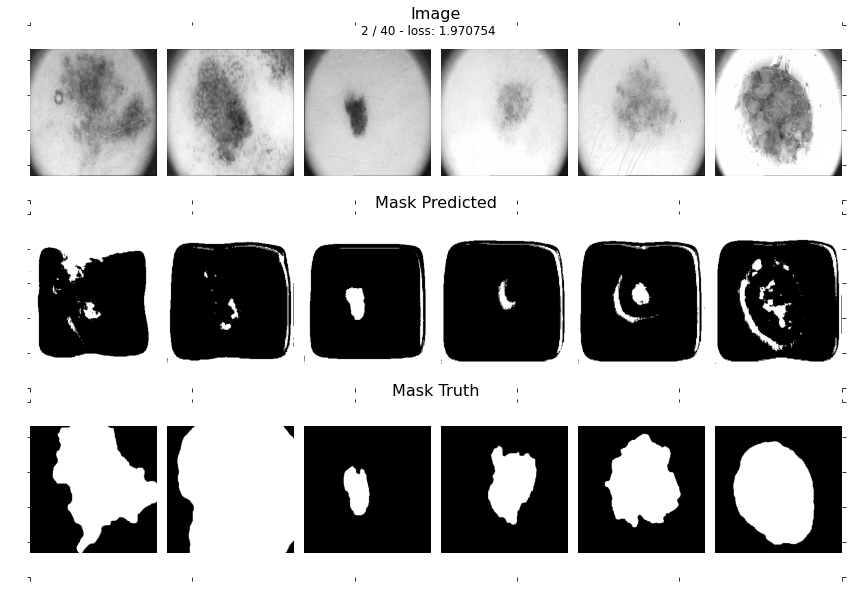

In [71]:
unet_model = UNet().to(device)
history = train(unet_model, optim.Adam(unet_model.parameters()), HausdorffDTLoss(alpha=0.5), 40, data_tr, data_val, data_ts)

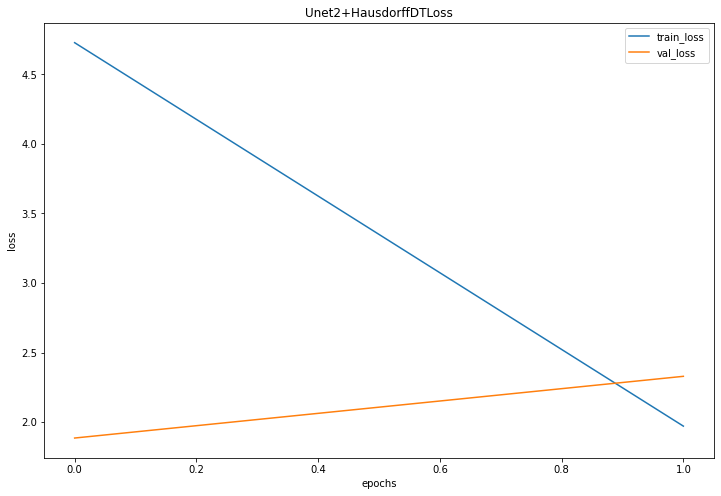

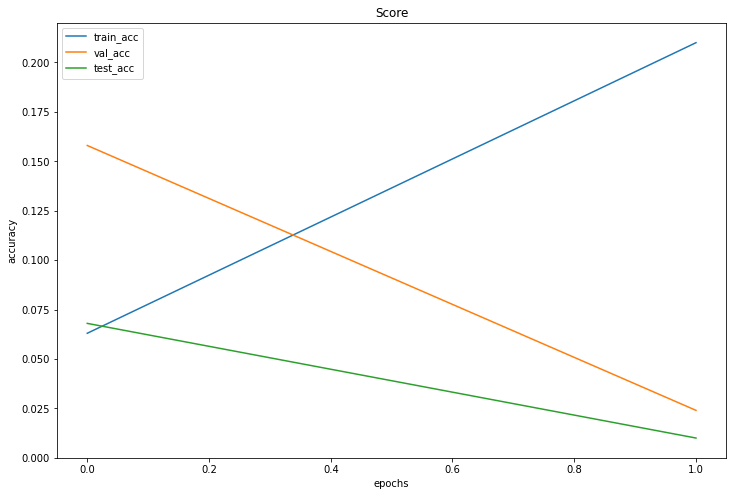

In [72]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+HausdorffDTLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [73]:
score_model(unet_model, iou_pytorch, data_val)

0.02400000113993883

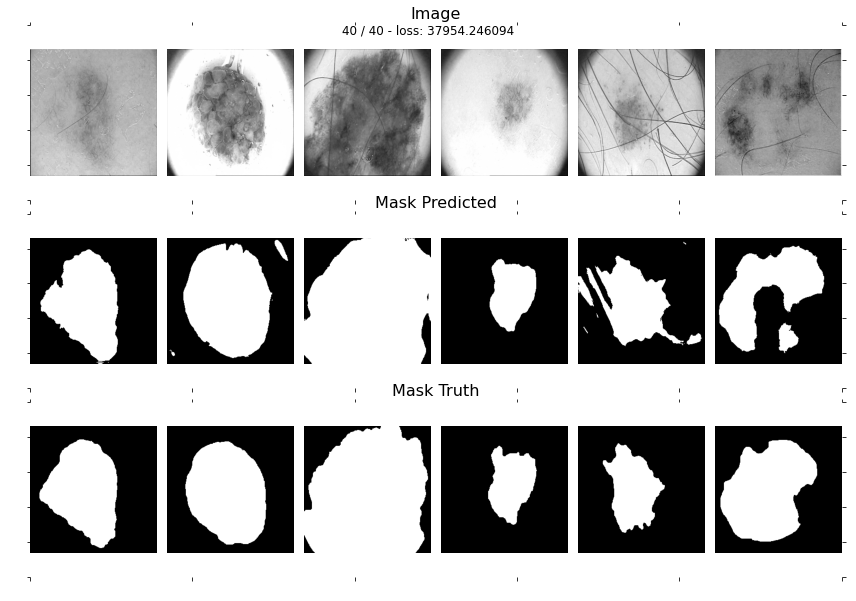

In [82]:
unet_model = UNet().to(device)
history = train(unet_model, optim.Adam(unet_model.parameters()), AsymmetricLoss(gamma_neg=1, gamma_pos=0.5, clip=0.3), 40, data_tr, data_val, data_ts)

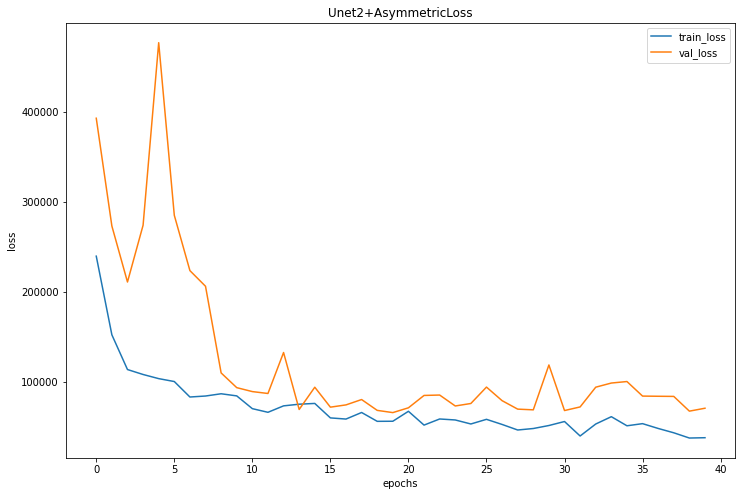

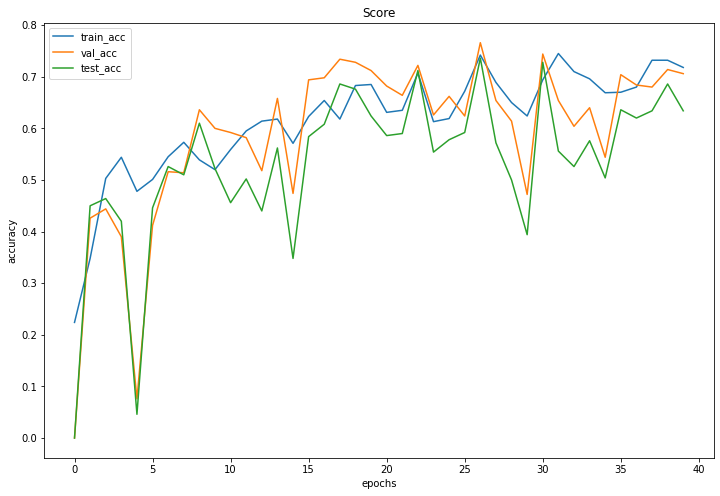

In [84]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+AsymmetricLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [85]:
score_model(unet_model, iou_pytorch, data_val)

0.706000030040741

хм, интересно, что при найденных гипер параметрах этот лосс вполне себе не плох, но нужно хорошо подбирать clip

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

|                       |  | Accuracy (val) | epochs |
| --------------------- |  | -------------- | ------ |
| SegNet+BCE            |  | 75.4           | 40    |
| SegNet+Dice           |  | 70.6             | 40    |
| SegNet+SegmentLoss    |  | 72.2           | 40    |
| SegNet+FocalLoss      |  | 60.8           | 40    |
| SegNet+AsymmetricLoss |  | 69           | 40    |
| UNet2+BCE             |  | 71.4          | 40     |
| UNet2+WeightedSegmentLoss     |  | 75.4             | 40     |
| UNet2+AsymmetricLoss |  | 70.6           | 40    |

Были проверены две модели SegNet и UNet с нормализацией и с максимально похожими условиями, Adam оптимизатор, без step scheduler, на валидационной и тестовой выборке (к сожалению, забыл  запустить принт скора на тесте, но по графикам видно, что скоры на тесте несильно отличаются от валидационных, что хороший знак и лишь в нескольких местах модели оверфитились) Также в трейне была добавлена довольно простая проверка, если качество на тесте стало хуже, закончить тренировку. Лучше всех себя показал классический BCE и SegmentLoss(BCE+Dice) и Hybrid Segment loss (взвешенная сумма). Дополнительные лоссы (не все включены в отчет в виду совсем плохих результатов) не дали особо ничего. С другой стороны неожиданно хорошо показал себя AsymmetricLoss, - видимо в какие моменты градиент нестабилен, тут не столько хорош этот лосс, сколько нужно подбирать scheduler, добавлять clap и в целом  тюнить процесс тренировки . Графики обучения выше. В некоторых местах обучение повторюсь нестабильно (лоссы не добавлял в отчет, поскольку в разных случаях они по разному просчитывались и не имеет смысла их сравнивать между собой)

